In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.decoders import WordPiece as WordPieceDecoder
from tqdm.auto import tqdm
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

Device: cuda
Number of GPUs: 2


In [3]:
class WordPieceTokenizer:
    def __init__(self, vocab_size=20000, min_frequency=2):
        self.vocab_size = vocab_size
        self.min_frequency = min_frequency
        self.tokenizer = None
    
    def train(self, texts):
        self.tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))
        self.tokenizer.pre_tokenizer = Whitespace()
        trainer = WordPieceTrainer(
            vocab_size=self.vocab_size,
            min_frequency=self.min_frequency,
            special_tokens=["[UNK]", "[PAD]"]
        )
        self.tokenizer.train_from_iterator(texts, trainer)
        self.tokenizer.decoder = WordPieceDecoder(prefix="##")
    
    def encode(self, text):
        return self.tokenizer.encode(text).ids
    
    def encode_tokens(self, text):
        return self.tokenizer.encode(text).tokens
    
    def decode(self, ids):
        return self.tokenizer.decode(ids)

In [4]:
class FastCBOWDataset(Dataset):
    def __init__(self, encoded_corpus, window_size):
        self.data = encoded_corpus
        self.window_size = window_size
    
    def __len__(self):
        return len(self.data) - 2 * self.window_size
    
    def __getitem__(self, idx):
        actual_idx = idx + self.window_size
        
        # Convert to tensor here instead of storing as tensor
        target = torch.tensor(self.data[actual_idx], dtype=torch.long)
        
        context_left = self.data[actual_idx - self.window_size : actual_idx]
        context_right = self.data[actual_idx + 1 : actual_idx + self.window_size + 1]
        
        # Convert slices to tensors
        context = torch.tensor(context_left + context_right, dtype=torch.long)
        
        return context, target

In [5]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, emb_dim):
        super().__init__()
        self.in_embed = nn.Embedding(vocab_size, emb_dim)
        self.out_embed = nn.Embedding(vocab_size, emb_dim)

    def forward(self, context_ids, target_ids, neg_ids):
        context_vec = self.in_embed(context_ids)
        context_mean = context_vec.mean(dim=1)

        target_vec = self.out_embed(target_ids)
        neg_vec = self.out_embed(neg_ids)

        pos_score = torch.sum(context_mean * target_vec, dim=1)
        neg_score = torch.bmm(neg_vec, context_mean.unsqueeze(2)).squeeze(2)

        # 🔥 numerically stable loss
        pos_loss = F.logsigmoid(pos_score)
        neg_loss = F.logsigmoid(-neg_score).sum(dim=1)

        loss = -(pos_loss + neg_loss).mean()
        return loss

In [6]:
def collate_fn(batch):
    """Optimized collate function"""
    contexts, targets = zip(*batch)
    
    # Stack contexts directly (they're all same size for CBOW)
    context_tensor = torch.stack(contexts)
    target_tensor = torch.stack(targets)
    
    return context_tensor, target_tensor

In [7]:
def build_neg_dist(encoded_corpus, vocab_size):
    """Build negative sampling distribution"""
    counts = torch.zeros(vocab_size)
    for t in encoded_corpus:
        counts[t] += 1
    dist = counts ** 0.75
    dist /= dist.sum()
    return dist

In [8]:
def train_cbow(encoded_corpus, vocab_size, window_size, emb_dim=384,
               batch_size=512, neg_k=10, epochs=5, lr=0.003):
    """
    Optimized training with multi-GPU and mixed precision support
    """
    print("Creating dataset...")
    dataset = FastCBOWDataset(encoded_corpus, window_size)
    
    print("Setting up DataLoader...")
    # Increased num_workers and batch size for better GPU utilization
    loader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        collate_fn=collate_fn, 
        pin_memory=True, 
        num_workers=2,  # Increased workers
        # persistent_workers=True  # Keep workers alive between epochs
    )
    
    # Build negative sampling distribution on GPU
    neg_dist = build_neg_dist(encoded_corpus, vocab_size).to(device)
    
    def sample_neg(batch_size, k):
        """Sample negative examples on GPU"""
        return torch.multinomial(neg_dist, batch_size * k, replacement=True).view(batch_size, k)
    
    # Create model
    model = CBOW(vocab_size, emb_dim)
    
    # Multi-GPU support
    # if torch.cuda.device_count() > 1:
    #     print(f"Using {torch.cuda.device_count()} GPUs!")
    #     model = nn.DataParallel(model)
    
    model = model.to(device)
    
    # Optimizer
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    
    # Mixed precision training
    scaler = GradScaler()
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}")
        
        for context_ids, target_ids in pbar:
            B = context_ids.size(0)
            
            # Sample negatives on GPU
            neg_ids = sample_neg(B, neg_k)
            
            # Move to device
            context_ids = context_ids.to(device, non_blocking=True)
            target_ids = target_ids.to(device, non_blocking=True)
            neg_ids = neg_ids.to(device, non_blocking=True)
            
            # Mixed precision forward pass
            optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()
            
            with autocast():
                loss = model(context_ids, target_ids, neg_ids)
            
            # Backward pass with gradient scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            total_loss += loss.item()
            pbar.set_postfix(loss=loss.item())

            # if pbar.n % 100 == 0:
                # torch.cuda.empty_cache()
        
        scheduler.step()
        avg_loss = total_loss / len(loader)
        print(f"Epoch {epoch+1}: Avg Loss {avg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")
    
    # Return the base model if using DataParallel
    if isinstance(model, nn.DataParallel):
        return model.module
    return model

In [9]:
def vectorize_corpus_fast(texts, tokenizer, model, batch_size=512):
    """
    Optimized vectorization with GPU batching
    """
    model.eval()
    
    # Get base model if wrapped in DataParallel
    if isinstance(model, nn.DataParallel):
        embeddings = model.module.in_embed.weight.detach()
    else:
        embeddings = model.in_embed.weight.detach()
    
    all_vecs = []
    
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Vectorizing"):
            batch_texts = texts[i : i + batch_size]
            encodings = tokenizer.tokenizer.encode_batch(batch_texts)
            
            for enc in encodings:
                if len(enc.ids) == 0:
                    all_vecs.append(np.zeros(embeddings.shape[1]))
                else:
                    ids = torch.tensor(enc.ids, device=embeddings.device)
                    doc_vec = embeddings[ids].mean(dim=0).cpu().numpy()
                    all_vecs.append(doc_vec)
    
    return np.vstack(all_vecs)

In [10]:
# Main training code
print("Loading data...")
with open("/kaggle/input/datasets/luqu24who/datasettext/AllCombined.txt", "r", encoding="utf-8") as f:
    texts = [line.strip() for line in f if line.strip()]

texts = texts[:50000]

Loading data...


In [11]:
print("Training tokenizer...")
tokenizer = WordPieceTokenizer(vocab_size=20000)
tokenizer.train(texts)


Training tokenizer...





In [12]:
pad_id = tokenizer.tokenizer.token_to_id("[PAD]")
print("PAD id:", pad_id)

PAD id: 1


In [13]:

print("Encoding corpus...")
encodings = tokenizer.tokenizer.encode_batch(texts)
encoded_corpus = []
for enc in encodings:
    encoded_corpus.extend(enc.ids)

print(f"Corpus size: {len(encoded_corpus):,} tokens")
print(f"Memory: {len(encoded_corpus) * 8 / 1024**3:.2f} GB")

Encoding corpus...
Corpus size: 2,853,614 tokens
Memory: 0.02 GB


In [14]:
# Train with optimized settings
print("Training CBOW model...")
model = train_cbow(
    encoded_corpus, 
    vocab_size=20000, 
    window_size=5, 
    emb_dim=384,
    batch_size=512,  # Increased for multi-GPU
    neg_k=10, 
    epochs=5, 
    lr=0.003
)

Training CBOW model...
Creating dataset...
Setting up DataLoader...


/tmp/ipykernel_55/105458180.py:42: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 1/5:   0%|          | 0/5574 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/ipykernel_55/105458180.py:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: Avg Loss 5.9056, LR: 0.002714


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 2/5:   0%|          | 0/5574 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e237257af20>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e237257af20>Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    Traceback (most recent call la

Epoch 2: Avg Loss 2.3035, LR: 0.001964


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 3/5:   0%|          | 0/5574 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e237257af20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e237257af20>  File

Epoch 3: Avg Loss 1.7162, LR: 0.001036


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 4/5:   0%|          | 0/5574 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e237257af20>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e237257af20>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__

    Traceback (most recent call la

Epoch 4: Avg Loss 1.4871, LR: 0.000286


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 5/5:   0%|          | 0/5574 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e237257af20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in 

Epoch 5: Avg Loss 1.3786, LR: 0.000000


In [15]:

torch.save(model.state_dict(), '/kaggle/working/cbow_model.pth')
tokenizer.tokenizer.save('/kaggle/working/tokenizer.json')

print("Model and tokenizer saved!")

Model and tokenizer saved!


In [16]:
# model = CBOW(vocab_size=20000, emb_dim=384)
# model.load_state_dict(torch.load('/kaggle/working/cbow_model.pth'))
# model.to(device)
# model.eval()

# # Load tokenizer
# from tokenizers import Tokenizer
# loaded_tokenizer = Tokenizer.from_file('/kaggle/working/tokenizer.json')

In [17]:
if isinstance(model, nn.DataParallel):
    embeddings = model.module.in_embed.weight
else:
    embeddings = model.in_embed.weight


Loading sentiment data...
Vectorizing training data...


Vectorizing:   0%|          | 0/10 [00:00<?, ?it/s]

Vectorizing test data...


Vectorizing:   0%|          | 0/5 [00:00<?, ?it/s]

Training classifier...

CBOW F1: 0.7723


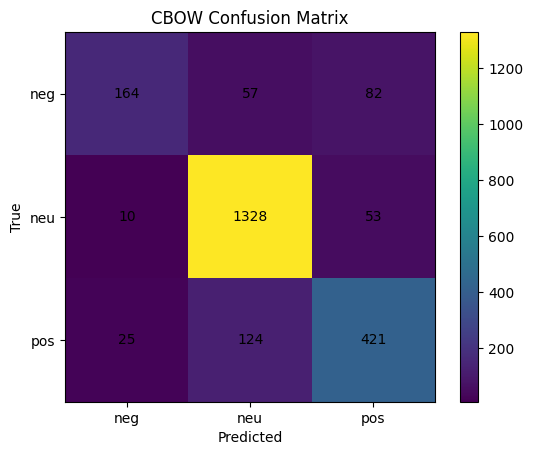

In [20]:
# Sentiment classification
print("\nLoading sentiment data...")
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix

lines = open("/kaggle/input/datasets/luqu24who/datasettext/Sentences_50Agree.txt", errors="ignore").read().splitlines()
texts_train = []
labels_train = []
label_map = {
    "negative": 0,
    "neutral": 1,
    "positive": 2
}

for line in lines:
    parts = line.rsplit("@", 1)
    texts_train.append(parts[0])
    labels_train.append(label_map[parts[1]])

print("Vectorizing training data...")
X_train = vectorize_corpus_fast(texts_train, tokenizer, model, batch_size=512)
y_train = labels_train

lines = open("/kaggle/input/datasets/luqu24who/datasettext/Sentences_AllAgree.txt", errors="ignore").read().splitlines()
texts_test = []
labels_test = []

for line in lines:
    parts = line.rsplit("@", 1)
    texts_test.append(parts[0])
    labels_test.append(label_map[parts[1]])

print("Vectorizing test data...")
X_test = vectorize_corpus_fast(texts_test, tokenizer, model, batch_size=512)
y_test = labels_test

print("Training classifier...")
clf = LogisticRegression(max_iter=2000, solver="liblinear")
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
f1 = f1_score(y_test, pred, average="macro")
print(f"\nCBOW F1: {f1:.4f}")

import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, pred)
plt.figure()
plt.imshow(cm)
plt.title("CBOW Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(3), ["neg", "neu", "pos"])
plt.yticks(range(3), ["neg", "neu", "pos"])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center")
plt.colorbar()
plt.show()

In [21]:
# VADER comparison
print("\nComparing with VADER...")
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

def vader_predict(texts):
    preds = []
    for t in texts:
        score = sia.polarity_scores(t)["compound"]
        if score >= 0.05:
            preds.append(2)
        elif score <= -0.05:
            preds.append(0)
        else:
            preds.append(1)
    return preds

vader_pred = vader_predict(texts_test)
vader_f1 = f1_score(y_test, vader_pred, average="macro")
print(f"VADER F1: {vader_f1:.4f}")


Comparing with VADER...
VADER F1: 0.4867
